AB2 Method

In [ ]:
import numpy as np

# Define equations of motion
def equations(t, y, rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi):
    x, vx, h, vy = y
    theta = np.arctan((vw - vx) / -vy)
    ax = (0.5 * rho * (vw - vx)**2 * cp * pi * r**2 * np.sin(theta)
          + 0.5 * rho * (vw - vx)**2 * cw * pi * L * D * np.sign(np.sin(theta))) / m \
         - 2 * np.cos(phi) * omega * vy
    ay = (0.5 * rho * vy**2 * cp * pi * r**2 * np.cos(theta)
          + 0.5 * rho * vy**2 * cb * pi * (D/2)**2 - m * g) / m \
         + 2 * np.cos(phi) * omega * vx
    return np.array([vx, ax, vy, ay])

# AB 2-step integrator
def ab2_integrate(func, t_span, y0, dt, args):
    t0, tf = t_span
    n_steps = int((tf - t0) / dt)
    t_values = np.linspace(t0, tf, n_steps + 1)
    y_values = np.zeros((len(y0), n_steps + 1))
    y_values[:, 0] = y0

    # First step using Forward Euler to start AB2
    f0 = func(t_values[0], y0, *args)
    y_values[:, 1] = y0 + dt * f0
    f1 = func(t_values[1], y_values[:, 1], *args)

    # Main AB2 loop
    for k in range(1, n_steps):
        y_values[:, k + 1] = y_values[:, k] + dt * (1.5 * f1 - 0.5 * f0)
        f0, f1 = f1, func(t_values[k + 1], y_values[:, k + 1], *args)

    return t_values, y_values

# Function to find minimum parachute radius using AB2 integration
def find_min_radius_ab2(rho, vw, cp, cb, cw, D, L, m, phi, g, omega, pi, max_vy, x0, vx0, h0, vy0):
    r = 0.005
    dt = 0.01
    t_span = (0, 50)

    while True:
        y0 = np.array([x0, vx0, h0, vy0])
        t_eval, y_eval = ab2_integrate(equations, t_span, y0, dt,
                                       (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi))
        vy_vals = y_eval[3, :]
        if np.max(np.abs(vy_vals)) < max_vy:
            return r
        r += 0.005

# constants
rho = 1.225
g = 9.81
omega = 7.292e-5
pi = np.pi
x0 = 0
vy0 = -0.1
cp = 1.3
cb = 0.8
cw = 1.0

# user inputs
vw0 = float(input("Enter wind speed (m/s): "))
wsf = float(input("Enter wind safety factor: "))
D = float(input("Enter diameter of rocket (cm): ")) / 100
L = float(input("Enter length of rocket (cm): ")) / 100
m = float(input("Enter mass of rocket (g): ")) / 1000
phi = np.deg2rad(float(input("Enter latitude of launch site (degrees): ")))
vx0 = float(input("Enter horizontal velocity at apogee (m/s): "))
h00 = float(input("Enter altitude at apogee (m): "))
hsf = float(input("Enter altitude safety factor: "))
max_vy = abs(float(input("Enter max allowable vertical velocity (m/s) (2–5 m/s suggested): ")))

# setup
vw = vw0 * wsf
h0 = h00 * hsf

# run AB2 simulation
min_r = find_min_radius_ab2(rho, vw, cp, cb, cw, D, L, m, phi, g, omega, pi, max_vy, x0, vx0, h0, vy0)
print(f"Minimum parachute radius required: {round(min_r * 100, 1)} cm")
# Test inputs
# wind speed 10 m/s
# WSF 2
# diameter 10
# length 50
# mass 1000 g
# latitude 20 degs
# vxo 10 m/s
#h00 500 m
# hsf 1
# max vy 2 m/s
# OUTPUT 105 cm


Minimum parachute radius required: 105.0 cm


Trajectory Model using Solve_IVP

AB2 Trajectory Model

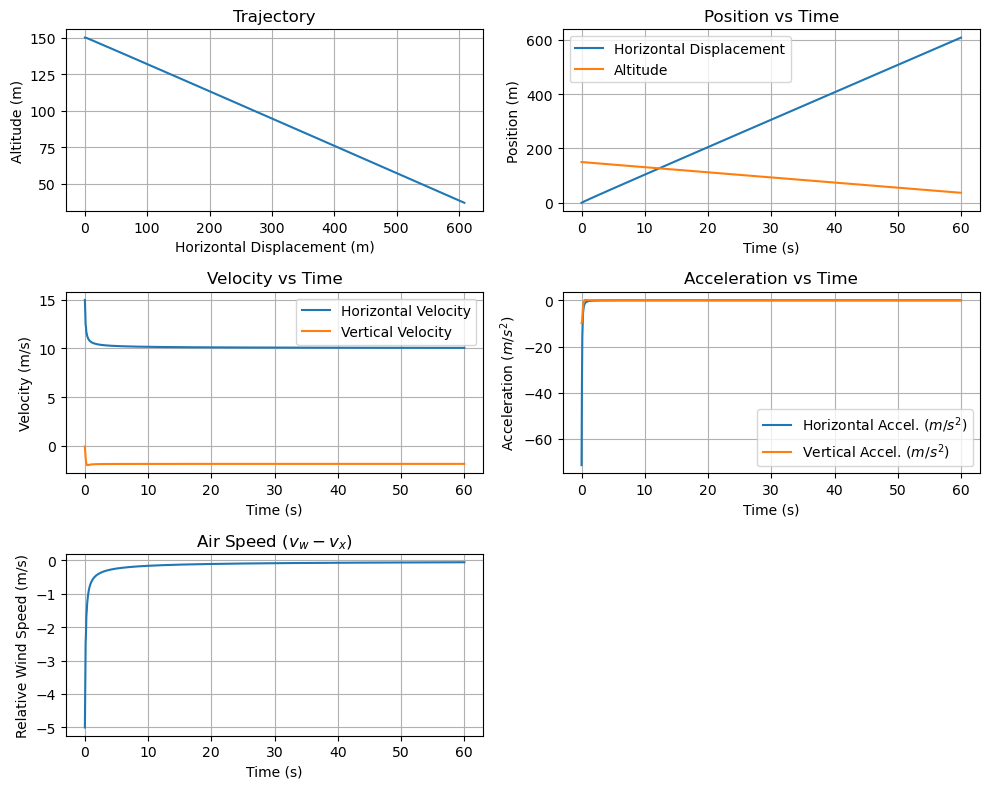

In [3]:
# ## AB2 Trajectory Simulation (Numerically matched to solve_ivp)

import numpy as np
import matplotlib.pyplot as plt

# --- Equations of motion ---
def equations(t, y, rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi):
    x, vx, h, vy = y
    theta = np.arctan2((vw - vx), -vy)
    ax = (0.5 * rho * (vw - vx)**2 * cp * pi * r**2 * np.sin(theta)
          + 0.5 * rho * (vw - vx)**2 * cw * pi * L * D * np.sign(np.sin(theta))) / m \
         - 2 * np.cos(phi) * omega * vy
    ay = (0.5 * rho * vy**2 * cp * pi * r**2 * np.cos(theta)
          + 0.5 * rho * vy**2 * cb * pi * (D / 2)**2 - m * g) / m \
         + 2 * np.cos(phi) * omega * vx
    return np.array([vx, ax, vy, ay])

# --- AB2 integrator with RK2 startup ---
def ab2_integrate(func, t_span, y0, dt, args):
    t0, tf = t_span
    n_steps = int((tf - t0) / dt)
    t_values = np.linspace(t0, tf, n_steps + 1)
    y_values = np.zeros((len(y0), n_steps + 1))
    y_values[:, 0] = y0

    # Initialize using RK2 (midpoint method) for accuracy
    f0 = func(t0, y0, *args)
    y_half = y0 + 0.5 * dt * f0
    f_half = func(t0 + 0.5 * dt, y_half, *args)
    y_values[:, 1] = y0 + dt * f_half

    f1 = func(t_values[1], y_values[:, 1], *args)

    # AB2 loop
    for k in range(1, n_steps):
        y_values[:, k + 1] = y_values[:, k] + dt * (1.5 * f1 - 0.5 * f0)
        f0, f1 = f1, func(t_values[k + 1], y_values[:, k + 1], *args)

    return t_values, y_values

# --- Inputs (identical to solve_ivp version) ---
rho = 1.225
vw0 = float(input("Enter wind speed (m/s): "))
wsf = float(input("Enter wind safety factor (enter 1 for simulation): "))
vw = vw0 * wsf

cp = 1.3
cb = 0.8
cw = 1.0
r = float(input("Enter parachute radius (cm): ")) / 100
D = float(input("Enter rocket body diameter (cm): ")) / 100
L = float(input("Enter rocket length (cm): ")) / 100
m = float(input("Enter rocket mass (g): ")) / 1000
phi = np.deg2rad(float(input("Enter launch site latitude (degrees): ")))
g = 9.81
omega = 7.292e-5
pi = np.pi

x0 = 0
vx0 = float(input("Enter horizontal velocity at apogee (m/s): "))
h00 = float(input("Enter altitude at apogee (m): "))
hsf = float(input("Enter altitude safety factor (enter 1 for simulation): "))
vy0 = -0.1
h0 = h00 * hsf
y0 = np.array([x0, vx0, h0, vy0])

t_duration = float(input("Enter simulation duration (s) (adjust length accordingly): "))
t_span = (0, t_duration)
dt = t_duration / 1000  # same number of time steps as solve_ivp

# --- Run AB2 integration ---
t_vals, y_vals = ab2_integrate(equations, t_span, y0, dt,
                               (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi))

x, vx, h, vy = y_vals

# --- Acceleration recomputation (same as solve_ivp) ---
theta = np.arctan2((vw - vx), -vy)
ax = (0.5 * rho * (vw - vx)**2 * cp * pi * r**2 * np.sin(theta)
      + 0.5 * rho * (vw - vx)**2 * cw * pi * L * D * np.sign(np.sin(theta))) / m \
     - 2 * np.cos(phi) * omega * vy
ay = (0.5 * rho * vy**2 * cp * pi * r**2 * np.cos(theta)
      + 0.5 * rho * vy**2 * cb * pi * (D / 2)**2 - m * g) / m \
     + 2 * np.cos(phi) * omega * vx

# --- Plot results (identical to solve_ivp layout) ---
plt.figure(figsize=(10, 8))

# 1. Trajectory
plt.subplot(3, 2, 1)
plt.plot(x, h, label='Trajectory')
plt.xlabel('Horizontal Displacement (m)')
plt.ylabel('Altitude (m)')
plt.title('Trajectory')
plt.grid()

# 2. Position vs Time
plt.subplot(3, 2, 2)
plt.plot(t_vals, x, label='Horizontal Displacement')
plt.plot(t_vals, h, label='Altitude')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position vs Time')
plt.legend()
plt.grid()

# 3. Velocity vs Time
plt.subplot(3, 2, 3)
plt.plot(t_vals, vx, label='Horizontal Velocity')
plt.plot(t_vals, vy, label='Vertical Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time')
plt.legend()
plt.grid()

# 4. Acceleration vs Time
plt.subplot(3, 2, 4)
plt.plot(t_vals, ax, label='Horizontal Accel. ($m/s^2$)')
plt.plot(t_vals, ay, label='Vertical Accel. ($m/s^2$)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration ($m/s^2$)')
plt.title('Acceleration vs Time')
plt.legend()
plt.grid()

# 5. Relative Air Speed
plt.subplot(3, 2, 5)
plt.plot(t_vals, vw - vx)
plt.xlabel('Time (s)')
plt.ylabel('Relative Wind Speed (m/s)')
plt.title('Air Speed ($v_w - v_x$)')
plt.grid()

plt.tight_layout()
plt.show()


Verify rocket has landed (Altitude has crossed y = 0) before running next block

In [11]:
print(f"Total descent time: {tf:.2f} s")
print(f"Horizontal landing displacement: {xf:.2f} m")
print(f"Horizontal landing speed: {vxf:.2f} m/s")
print(f"Vertical landing speed: {vyf:.2f} m/s")

Total descent time: 30.47 s
Horizontal landing displacement: 293.19 m
Horizontal landing speed: 9.84 m/s
Vertical landing speed: -3.29 m/s
